# WBIC

This notebook gives a tutorial on how to use Watanabe-Bayesian information criterion (WBIC) for feature selection. The WBIC is an information criterion. Similarly to other criteria (AIC, BIC, DIC) the WBIC endeavors to find the most parsimonious model, i.e., the model that balances fit with complexity. In other words a model (or set of features) that optimizes WBIC should neither over nor under fit the available data. 

In this tutorial a data set is simulated using the damped linear trend (DLT) model. This data set is then used to fit DLT models with varying number of features as well as a global local trent model (GLT), and a Error-Trend-Seasonal (ETS) model. The WBIC criteria is then show to find the true model. 


In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import orbit
print(orbit.__version__)
from orbit.models import DLT,ETS, KTRLite, LGT
from orbit.utils.simulation import make_trend, make_regression

print(orbit.__version__)

%load_ext autoreload
%autoreload 2

1.1.0dev
1.1.0dev


In [2]:
pwd()

'/Users/gavin.steininger/Desktop/WBIC_pyro/orbit/examples'

## Simulated Data

This block of code creats random data set (365 observations with 10 features) assuming a DLT model. Of the 10 features 5 are effective regressors; i.e., they are used in the true model to create the data.

As an exerise left to the user once you have run the code once try changing the NUM_OF_EFFECTIVE_REGRESSORS (line 2), the SERIES_LEN (line 3), and the SEED (line 4) to see how it effects the results. 

In [3]:
NUM_OF_REGRESSORS = 10
NUM_OF_EFFECTIVE_REGRESSORS = 5
SERIES_LEN = 365
SEED = 1
# sample some coefficients
COEFS = np.random.default_rng(SEED).uniform(-1, 1, NUM_OF_EFFECTIVE_REGRESSORS)
trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS)
print(regression.shape, x.shape)

# combine trend and the regression
y = trend + regression
y = y - y.min()


x_extra = np.random.normal(0, 1, (SERIES_LEN, NUM_OF_REGRESSORS - NUM_OF_EFFECTIVE_REGRESSORS))
x = np.concatenate([x, x_extra], axis=-1)
print(x.shape)

x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt
print(df.shape)
print(df.head())



(365,) (365, 5)
(365, 10)
(365, 12)
          y        x1        x2        x3        x4        x5        x6  \
0  3.192673  0.172792  0.000000  0.165219 -0.000000  0.452678 -0.087092   
1  3.951436  0.223187 -0.000000  0.290559  0.182286  0.147066  0.150738   
2  4.122889  0.014211  0.273356 -0.368227 -0.081455 -0.241060  1.361627   
3  1.669311  0.299423  0.019861 -0.146228 -0.390954 -0.128596 -0.558905   
4  3.567194  0.004071 -0.137801  0.647032  0.000000 -0.000000 -0.355704   

         x7        x8        x9       x10       date  
0 -0.986402 -0.672840 -0.161679 -0.324257 2016-01-10  
1  0.317149 -1.118538  0.373721 -1.953525 2016-01-17  
2 -0.099264 -0.418049  1.349128  0.320697 2016-01-24  
3  0.364997  1.055342  0.013019  0.085396 2016-01-31  
4 -1.122178  0.149475  0.003326  0.888810 2016-02-07  


This section of code fits the DLT model to the simulated data for each number of features. 

In [4]:
WBIC_ls = []
for k in range(0, NUM_OF_REGRESSORS):
    regressor_col = x_cols[:k + 1]
    dlt_mod = DLT(
        response_col=response_col,
        date_col=dt_col,
        regressor_col=regressor_col,
        seed=2022,
        # fixing the smoothing parameters to learn regression coefficients more effectively
        level_sm_input=0.01,
        slope_sm_input=0.01,
        num_warmup=4000,
        num_sample=4000,
        )
    WBIC_temp = dlt_mod.fit_wbic(df=df) 
    print(k)
    print(WBIC_temp)
    print('------------------------------------------------------------------')
    WBIC_ls.append(WBIC_temp)

    


Gradient evaluation took 0.000637 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.37 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00061 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.1 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000593 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.93 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000617 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.17 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  400 / 2000 [ 2

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


0
1198.1800976963348
------------------------------------------------------------------

Gradient evaluation took 0.000877 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.77 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000864 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.64 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000977 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.77 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000993 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.93 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


1
1126.249783978133
------------------------------------------------------------------

Gradient evaluation took 0.00064 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.4 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000768 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.68 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000934 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.34 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000696 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.96 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


2
1117.2318404578557
------------------------------------------------------------------

Gradient evaluation took 0.00068 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.8 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.002492 seconds
1000 transitions using 10 leapfrog steps per transition would take 24.92 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000661 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000651 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.51 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 /

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


3
1052.2484457584642
------------------------------------------------------------------

Gradient evaluation took 0.000709 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.09 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001548 seconds
1000 transitions using 10 leapfrog steps per transition would take 15.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000659 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000676 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.76 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


4
1051.9229011183613
------------------------------------------------------------------

Gradient evaluation took 0.000654 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.54 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 0.000758 seconds
Gradient evaluation took 0.000723 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.58 seconds.
Adjust your expectations accordingly!
1000 transitions using 10 leapfrog steps per transition would take 7.23 seconds.

Adjust your expectations accordingly!




Gradient evaluation took 0.000636 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.36 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


5
1057.6086167667434
------------------------------------------------------------------

Gradient evaluation took 0.000715 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.15 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000765 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000626 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.26 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000689 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.89 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 15.3375 seconds (Warm-up)
               2.63354 seconds (Sampling)
               17.971 seconds (Total)

6
1063.487588511451
------------------------------------------------------------------

Gradient evaluation took 0.000713 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.13 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000741 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.41 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000722 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.22 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000947 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.47 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 16.3155 seconds (Warm-up)
               2.64788 seconds (Sampling)
               18.9634 seconds (Total)

7
1070.1536414995428
------------------------------------------------------------------

Gradient evaluation took 0.000741 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.41 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000942 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.42 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001773 seconds
1000 transitions using 10 leapfrog steps per transition would take 17.73 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000633 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.33 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 16.6675 seconds (Warm-up)
               2.80732 seconds (Sampling)
               19.4749 seconds (Total)

8
1074.9779019223874
------------------------------------------------------------------

Gradient evaluation took 0.000721 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.21 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000661 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000678 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.78 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000641 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.41 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


9
1080.1234043015866
------------------------------------------------------------------


The plot below shows the WBIC vs the number of features (blue line). The true model is indicated by the vertical red line. The horizontal gray line shows the minimum (optimal) value.

Text(0.5, 0, '# number of Features')

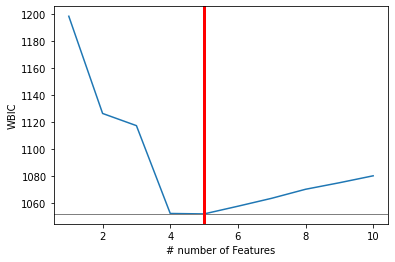

In [5]:
num_reg_ls = list(range(1, NUM_OF_REGRESSORS+1))
plt.plot(num_reg_ls, WBIC_ls, )
plt.axhline(y=min(WBIC_ls), color='grey', linewidth = 1)
plt.axvline(x=NUM_OF_EFFECTIVE_REGRESSORS, color='red', linewidth = 3)
plt.ylabel("WBIC")
plt.xlabel("# number of Features")

In [6]:
print(WBIC_ls)

[1198.1800976963348, 1126.249783978133, 1117.2318404578557, 1052.2484457584642, 1051.9229011183613, 1057.6086167667434, 1063.487588511451, 1070.1536414995428, 1074.9779019223874, 1080.1234043015866]


The block try the LGT and ETS models. 

In [7]:
lgt = LGT(response_col=response_col,
          date_col=dt_col,
          regressor_col=regressor_col,
          seasonality=52,
          estimator='stan-mcmc',
          seed=8888)
WBIC_lgt = lgt.fit_wbic(df=df) 
print(WBIC_lgt)

ets = ETS(
        response_col=response_col,
        date_col=dt_col,
        seed=2020,
        # fixing the smoothing parameters to learn regression coefficients more effectively
        level_sm_input=0.01,
    )

WBIC_ets = ets.fit_wbic(df=df) 
print(WBIC_ets)

WBIC_ls.append(WBIC_lgt)
WBIC_ls.append(WBIC_ets)




Gradient evaluation took 0.000718 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.18 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000706 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.06 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00074 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.4 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000793 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.93 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: l[1] is -9.33699, but must be greater than or equal to 0  (in 'unknown file name' at line 130)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: l[1] is -4.30108, but must be greater than or equal to 0  (in 'unknown file name' at line 130)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: T

Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
Iteration:  75 / 250 [ 30%]  (Warmup)
Iteration:  75 / 250 [ 30%]  (Warmup)
Iteration:  75 / 250 [ 30%]  (Warmup)
Iteration:  75 / 250 [ 30%]  (Warmup)
Iteration: 100 / 250 [ 40%]  (Warmup)
Iteration: 100 / 250 [ 40%]  (Warmup)
Iteration: 100 / 250 [ 40%]  (Warmup)
Iteration: 100 / 250 [ 40%]  (Warmup)
Iteration: 125 / 250 [ 50%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: l[1] is -1.58382, but must be greater than or equal to 0  (in 'unknown file name' at line 130)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 125 / 250 [ 50%]  (Warmup)
Iteration: 125 / 250 [ 50%]  (Warmup)
Iteration: 150 / 250 [ 60%]  (Warmup)
Iteration: 125 / 250 [ 50%]  (Warmup)
Iteration: 150 / 250 [ 60%]  (Warmup)
Iteration: 150 / 250 [ 60%]  (Warmup)
Iteration: 175 / 250 [ 70%]  (Warmup)
Iteration: 150 / 250 [ 60%]  (Warmup)
Iteration: 175 / 250 [ 70%]  (Warmup)
Iteration: 200 / 250 [ 80%]  (Warmup)
Iteration: 175 / 250 [ 70%]  (Warmup)
Iteration: 200 / 250 [ 80%]  (Warmup)
Iteration: 225 / 250 [ 90%]  (Warmup)
Iteration: 226 / 250 [ 90%]  (Sampling)
Iteration: 175 / 250 [ 70%]  (Warmup)
Iteration: 200 / 250 [ 80%]  (Warmup)
Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 1.72753 seconds (Warm-up)
               0.092739 seconds (Sampling)
               1.82026 seconds (Total)

Iteration: 225 / 250 [ 90%]  (Warmup)
Iteration: 226 / 250 [ 90%]  (Sampling)
Iteration: 225 / 250 [ 90%]  (Warmup)
Iteration: 250 / 250 [100%]  (Sampling)
Iteration: 226 / 250 [ 90%]  (Sampling)

 Elapsed Time: 1.83906 secon

To run all diagnostics call pystan.check_hmc_diagnostics(fit)



 Elapsed Time: 1.92741 seconds (Warm-up)
               0.092197 seconds (Sampling)
               2.01961 seconds (Total)

Iteration: 225 / 250 [ 90%]  (Warmup)
Iteration: 226 / 250 [ 90%]  (Sampling)
Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 2.03577 seconds (Warm-up)
               0.096785 seconds (Sampling)
               2.13255 seconds (Total)

1127.7871511053763

Gradient evaluation took 0.000258 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.58 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000219 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.19 seconds.
Adjust your expectations accordingly!



Iteration:   1 / 250 [  0%]  (Warmup)
Gradient evaluation took 0.000227 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.27 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000191 seconds
1000 transitions using 10 leapfrog steps

1192.5241253376187


Text(0.5, 0, '# number of Features')

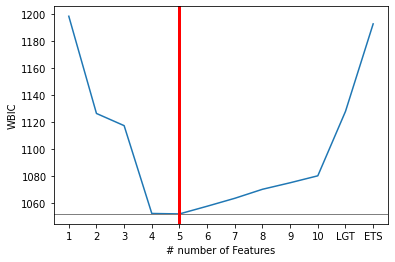

In [13]:
num_reg_ls = list(range(1, NUM_OF_REGRESSORS+1)) + ['LGT','ETS']
plt.plot(num_reg_ls, WBIC_ls, )
plt.axhline(y=min(WBIC_ls), color='grey', linewidth = 1)
plt.axvline(x=NUM_OF_EFFECTIVE_REGRESSORS-1, color='red', linewidth = 3) # because list type is mixed index from 1
plt.ylabel("WBIC")
plt.xlabel("# number of Features")

5

The next block of code tests the WBIC with different random seeds. This code can be very slow! 

In [ ]:
works_ls = []
for i in range(0,10):
    NUM_OF_REGRESSORS = 6
    NUM_OF_EFFECTIVE_REGRESSORS = 3
    SERIES_LEN = 365
    SEED = 1+i
    # sample some coefficients
    COEFS = np.random.default_rng(SEED).uniform(-1, 1, NUM_OF_EFFECTIVE_REGRESSORS)
    trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
    x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS)
    print(regression.shape, x.shape)
    
    # combine trend and the regression
    y = trend + regression
    y = y - y.min()
    
    
    x_extra = np.random.normal(0, 1, (SERIES_LEN, NUM_OF_REGRESSORS - NUM_OF_EFFECTIVE_REGRESSORS))
    x = np.concatenate([x, x_extra], axis=-1)
    
    x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
    response_col = "y"
    dt_col = "date"
    obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
    # make a data frame for orbit inputs
    df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
    # make some dummy date stamp
    dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
    df['date'] = dt

    WBIC_ls = []
    for k in range(0, NUM_OF_REGRESSORS):
        regressor_col = x_cols[:k + 1]
        dlt_mod = DLT(
            response_col=response_col,
            date_col=dt_col,
            regressor_col=regressor_col,
            seed=2022,
            # fixing the smoothing parameters to learn regression coefficients more effectively
            level_sm_input=0.01,
            slope_sm_input=0.01,
            num_warmup=1000,
            num_sample=1000,
            )
        WBIC_temp = dlt_mod.fit_wbic(df=df)
        print(i)
        print(k)
        print(WBIC_temp)
        print('------------------------------------------------------------------')
        WBIC_ls.append(WBIC_temp)
    
    works_temp = (np.argmin(WBIC_ls)+ 1) == NUM_OF_EFFECTIVE_REGRESSORS    
    works_ls.append(works_temp)
    print('------------------------------------------------------------------')
    print(i)
    print(works_ls)
    print(WBIC_ls)
    print('------------------------------------------------------------------')
        

    
    